In [1]:
# import Library and some random image data set
import tensorflow as tf
import numpy      as np
import seaborn    as sns 
import pandas     as pd
import os
import matplotlib.pyplot as plt
np.random.seed(78); tf.set_random_seed(78)

# get some of the STL data set
from sklearn.preprocessing import OneHotEncoder
from skimage import util 
from skimage.transform import resize
from skimage.io import imread
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read all of the data
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
    
train_images = read_all_images("../../../DataSet/STL10/stl10_binary/train_X.bin") / 255.0
train_labels = read_labels    ("../../../DataSet/STL10/stl10_binary/train_Y.bin")
test_images  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
train_labels = label_encoder.fit_transform(train_labels.reshape((-1,1)))
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))

print(train_images.shape,train_images.max(),train_images.min())
print(train_labels.shape,train_labels.max(),train_labels.min())
print(test_images.shape,test_images.max(),test_images.min())
print(test_labels.shape,test_labels.max(),test_labels.min())

(5000, 96, 96, 3) 1.0 0.0
(5000, 10) 1.0 0.0
(8000, 96, 96, 3) 1.0 0.0
(8000, 10) 1.0 0.0


In [3]:
# create the layers
def tf_softmax(x): return tf.nn.softmax(x)

def tf_elu(x):   return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_tanh(x):   return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

class CNN():

    def __init__(self,k,inc,out, stddev=0.05,which_reg=0,act=tf_relu,d_act=d_tf_relu):
        self.w          = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v   = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg  = which_reg
        
    def getw(self): return [self.w,self.b]

    def feedforward(self,input,stride=1,padding='SAME'):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding) 
        self.layerA = self.act(self.layer)
        return [self.layer,self.layerA]

    def backprop(self,gradient,stride=1,padding='SAME'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad        = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = tf.shape(self.w),  out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding) / batch_size
        grad_pass   = tf.nn.conv2d_backprop_input (input_sizes = tf.shape(self.input),filter= self.w,out_backprop = grad_middle,strides=[1,stride,stride,1],padding=padding)
        
        return [grad,grad_pass]
    
class tf_batch_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[1,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.batch * self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x

class tf_layer_norm_layer():
    
    def __init__(self,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[vector_shape,1,1,1],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w * self.c)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
    
class tf_instance_norm_layer():
    
    def __init__(self,batch_size,vector_shape,axis):
        self.moving_mean = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.moving_vari = tf.Variable(tf.zeros(shape=[batch_size,1,1,vector_shape],dtype=tf.float32))
        self.axis        = axis
        
    def feedforward(self,input,training_phase=True,eps = 1e-8):
        self.input = input
        self.input_size          = self.input.shape
        self.batch,self.h,self.w,self.c = self.input_size[0].value,self.input_size[1].value,self.input_size[2].value,self.input_size[3].value

        # Training Moving Average Mean         
        def training_fn():
            self.mean    = tf.reduce_mean(self.input,axis=self.axis ,keepdims=True)
            self.var     = tf.reduce_mean(tf.square(self.input-self.mean),axis=self.axis,keepdims=True)
            centered_data= (self.input - self.mean)/tf.sqrt(self.var + eps)
            
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean*0.9 + 0.1 * self.mean ))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari*0.9 + 0.1 * self.var  ))
            return centered_data,update_variable
        
        # Testing Moving Average Mean        
        def  testing_fn():
            centered_data   = (self.input - self.moving_mean)/tf.sqrt(self.moving_vari + eps)
            update_variable = []
            update_variable.append(tf.assign(self.moving_mean,self.moving_mean))
            update_variable.append(tf.assign(self.moving_vari,self.moving_vari))
            return centered_data,update_variable
        
        self.output,update_variable = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_variable
    
    def backprop(self,grad,eps = 1e-8):
        change_parts = 1.0 /(self.h * self.w)
        grad_sigma   = tf.reduce_sum( grad *  (self.input-self.mean)     ,axis=self.axis,keepdims=True) * -0.5 * (self.var+eps) ** -1.5
        grad_mean    = tf.reduce_sum( grad *  (-1./tf.sqrt(self.var+eps)),axis=self.axis,keepdims=True) + grad_sigma * change_parts * 2.0 * tf.reduce_sum((self.input-self.mean),axis=self.axis,keepdims=True) * -1
        grad_x       = grad * 1/(tf.sqrt(self.var+eps)) + grad_sigma * change_parts * 2.0 * (self.input-self.mean) + grad_mean * change_parts
        return grad_x
  
class tf_box_cox():
    
    def __init__(self,lmbda=2.0):
        self.lmbda = lmbda
    
    def feedforward(self,data):
        self.input = data
        self.layer = (tf.pow((data + 1.0),self.lmbda) - 1.0)/self.lmbda
        return self.layer 
    
    def backprop(self,grad):
        grad_input = tf.pow((self.input + 1),self.lmbda-1.0)
        
        # Grad respect to the lmbda value (not tested!)
        grad_lmbda = tf.pow((self.input+1),self.lmbda) * \
        (tf.log(self.input+1)*self.lmbda -1) + 1
        grad_lmbda = grad_lmbda / (self.lmbda ** 2)
        
        return grad_input * grad

class tf_min_max_layer():
    
    def __init__(self,vector_shape,user_max=1.0,user_min=0.0):
        self.moving_min = tf.Variable(tf.zeros(shape=(vector_shape,1),dtype=tf.float32))
        self.moving_max = tf.Variable(tf.zeros(shape=(vector_shape,1),dtype=tf.float32))
        self.user_min   = tf.Variable(user_min,dtype=tf.float32); 
        self.user_max   = tf.Variable(user_max,dtype=tf.float32); 
        
    def feedforward(self,input,training_phase):
        self.input    = input
        self.min_vec  = tf.reduce_min(input,-1)[:,None]
        self.min_index= tf.argmin(input,-1)
        self.max_vec  = tf.reduce_max(input,-1)[:,None]
        self.max_index= tf.argmax(input,-1)
        
        def training_fn():
            normalized_data = (self.user_max-self.user_min)  * \
            ((self.input - self.min_vec)/(self.max_vec - self.min_vec))          + self.user_min
            
            update_min_max = []
            update_min_max.append(tf.assign(self.moving_min,self.moving_min * 0.9 + 0.1 * self.min_vec))
            update_min_max.append(tf.assign(self.moving_max,self.moving_max * 0.9 + 0.1 * self.max_vec))
            return normalized_data,update_min_max
        
        # Testing Moving Average Mean        
        def  testing_fn():
            normalized_data = (self.user_max-self.user_min) * \
            ((self.input - self.moving_min)/(self.moving_max - self.moving_min)) + self.user_min
            
            update_min_max = []
            update_min_max.append(tf.assign(self.moving_min,self.moving_min))
            update_min_max.append(tf.assign(self.moving_max,self.moving_max))
            return normalized_data,update_min_max
        
        self.output,update_min_max = tf.cond(training_phase,true_fn=training_fn,false_fn=testing_fn)
        return self.output,update_min_max
    
    def backprop(self,grad):
        grad1   = grad
        
        # Create Mask for min / max value for row
        indices = tf.range(0, self.input.shape[0].value,dtype=tf.int64)
        min_indices = tf.stack([indices, self.min_index], axis=1)
        max_indices = tf.stack([indices, self.max_index], axis=1)
        grad_min = tf.cast(tf.sparse_to_dense(min_indices, self.input.shape, sparse_values=1, default_value=0),dtype=tf.float32)
        grad_max = tf.cast(tf.sparse_to_dense(max_indices, self.input.shape, sparse_values=1, default_value=0),dtype=tf.float32)
        
        grad_max_min = 1.0/(self.max_vec-self.min_vec)
        grad_pass    = grad1 * (self.user_max-self.user_min) * (
            grad_max_min + \
            (self.input - self.max_vec)/tf.square(grad_max_min) * grad_min + \
            (self.min_vec - self.input)/tf.square(grad_max_min) * grad_max
        )
        
        return grad_pass

def show_histogram(layer1,layer1a,grad1w,grad1p):
    plt.figure(figsize=(20,5))
    plt.subplot(141); plt.hist(layer1. ravel(),batch_size); plt.title('layer')
    plt.subplot(142); plt.hist(layer1a.ravel(),batch_size); plt.title('layer a')
    plt.subplot(143); plt.hist(grad1w.ravel(),batch_size); plt.title('grad w')
    plt.subplot(144); plt.hist(grad1p.ravel(),batch_size); plt.title('grad p')
    plt.show()   

In [4]:
# declare layers and the data 
sess = tf.InteractiveSession()
batch_size = 20 
x_data     = train_images[:batch_size].astype(np.float32)
x_label    = train_labels[:batch_size].astype(np.float32)

l1 = CNN(3,3, 16); l1bc = tf_box_cox()
l2 = CNN(3,16,16); l2bc = tf_box_cox()
l3 = CNN(3,16,16); l3bc = tf_box_cox()
l4 = CNN(3,16,16); l4bc = tf_box_cox()
l5 = CNN(3,16,16); l5bc = tf_box_cox()
l6 = CNN(3,16,10); 

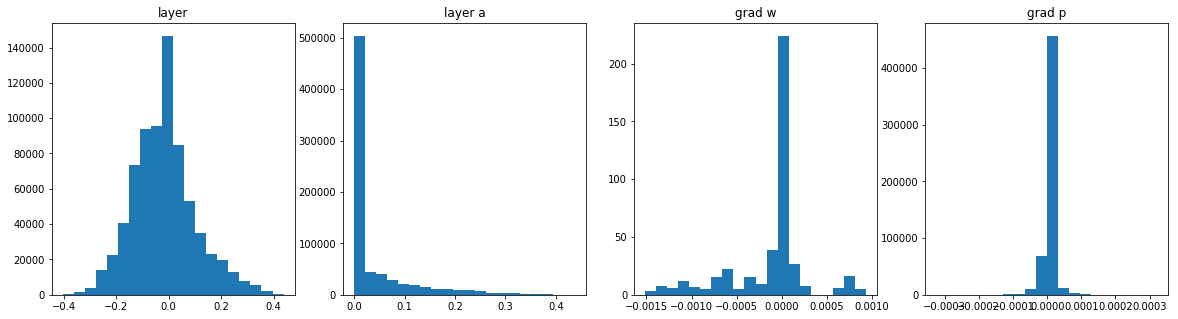

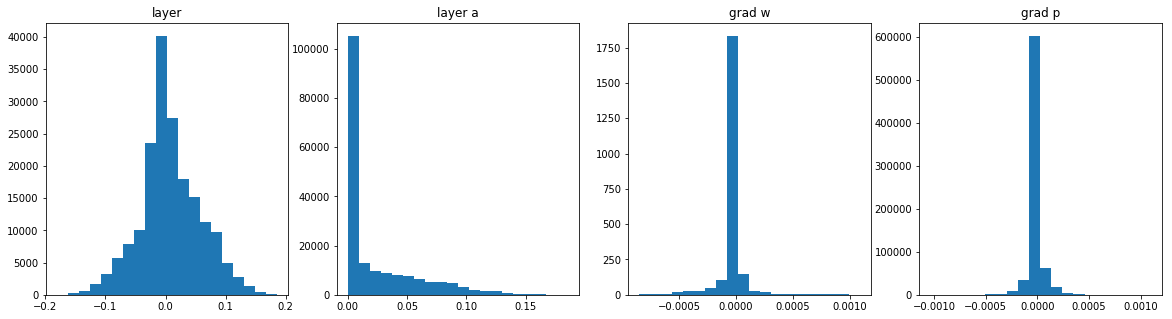

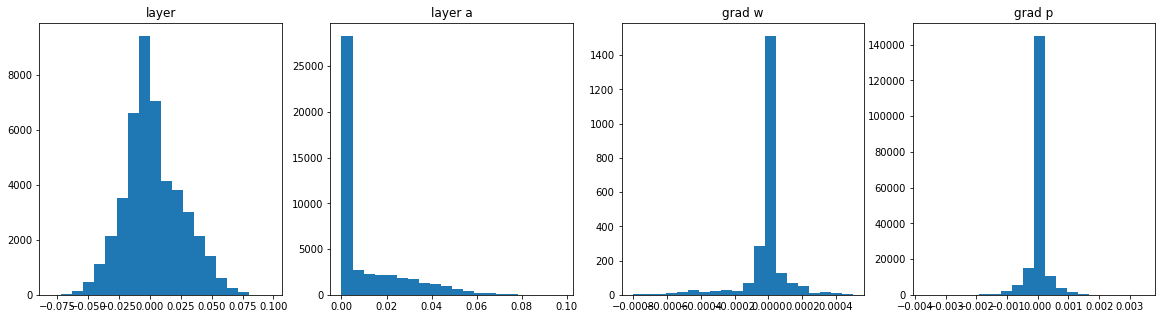

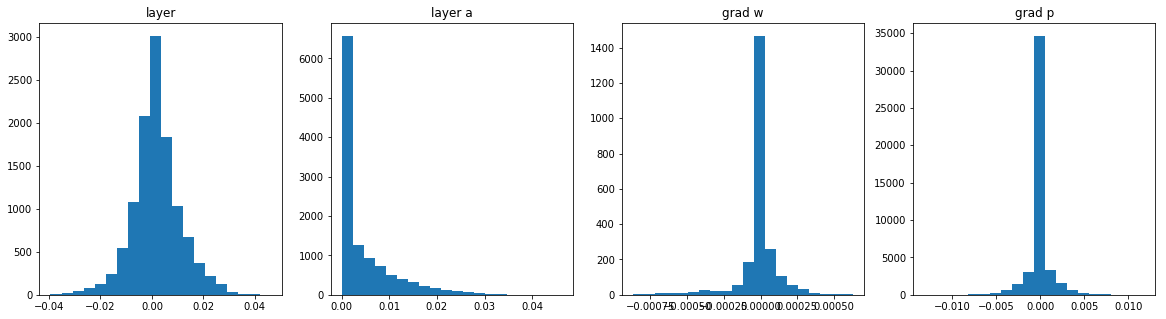

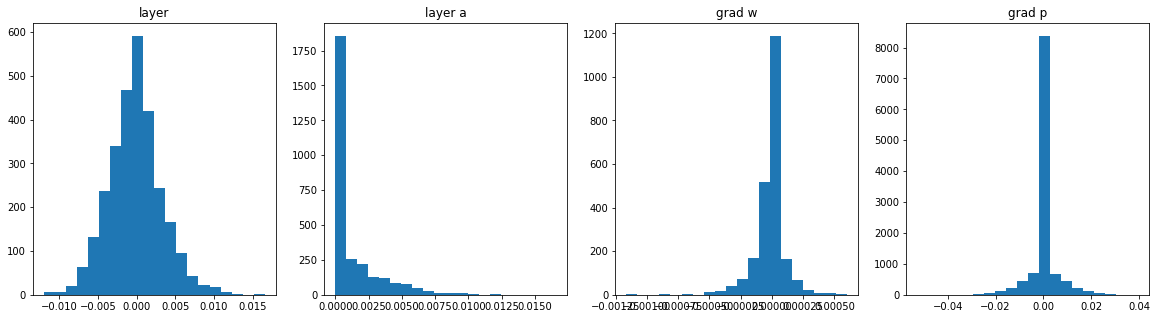

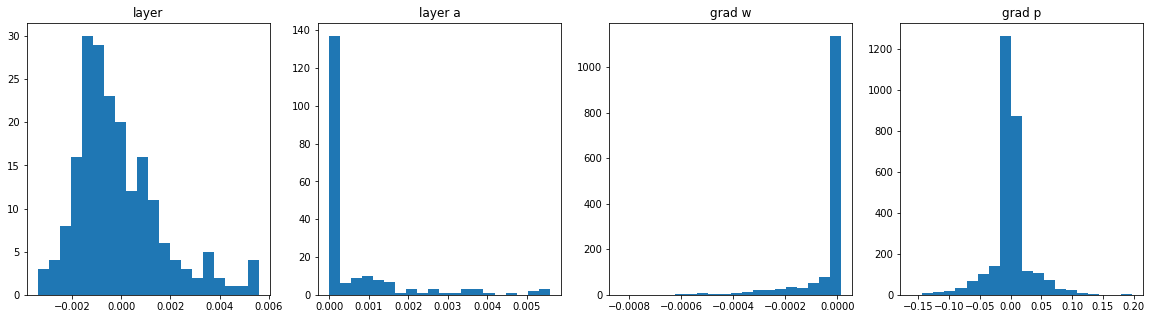

In [5]:
# box cox
sess.run(tf.global_variables_initializer())
is_train = tf.placeholder_with_default(True,())
layer1,layer1a = l1.feedforward(x_data, stride=2)
layer1b        = l1bc.feedforward(layer1a)

layer2,layer2a = l2.feedforward(layer1b,stride=2)
layer2b        = l2bc.feedforward(layer2a)

layer3,layer3a = l3.feedforward(layer2b,stride=2)
layer3b        = l3bc.feedforward(layer3a)

layer4,layer4a = l4.feedforward(layer3b,stride=2)
layer4b        = l4bc.feedforward(layer4a)

layer5,layer5a = l5.feedforward(layer4b,stride=2)
layer5b        = l5bc.feedforward(layer5a)

layer6,layer6a = l6.feedforward(layer5b,stride=1,padding='VALID')

final_softmax  = tf_softmax(tf.squeeze(layer6a))
cost  = - tf.reduce_mean(x_label * tf.log(final_softmax + 1e-8))
dcost = (tf.squeeze(layer6a) - x_label)[:,None,None,:]

grad6w,grad6p = l6.backprop(dcost,stride=1,padding='VALID')
grad6pb = l5bc.backprop(grad6p)
grad5w,grad5p = l5.backprop(grad6pb,stride=2)
grad5pb = l4bc.backprop(grad5p)
grad4w,grad4p = l4.backprop(grad5pb,stride=2)
grad4pb = l3bc.backprop(grad4p)
grad3w,grad3p = l3.backprop(grad4pb,stride=2)
grad3pb = l2bc.backprop(grad3p)
grad2w,grad2p = l2.backprop(grad3pb,stride=2)
grad2pb = l1bc.backprop(grad2p)
grad1w,grad1p = l1.backprop(grad2pb,stride=2)

# evaluate all of the layers
layer1,layer1a=layer1.eval(),layer1a.eval()
layer2,layer2a=layer2.eval(),layer2a.eval()
layer3,layer3a=layer3.eval(),layer3a.eval()
layer4,layer4a=layer4.eval(),layer4a.eval()
layer5,layer5a=layer5.eval(),layer5a.eval()
layer6,layer6a=layer6.eval(),layer6a.eval()

grad6w,grad6p = grad6w.eval(),grad6p.eval()
grad5w,grad5p = grad5w.eval(),grad5p.eval()
grad4w,grad4p = grad4w.eval(),grad4p.eval()
grad3w,grad3p = grad3w.eval(),grad3p.eval()
grad2w,grad2p = grad2w.eval(),grad2p.eval()
grad1w,grad1p = grad1w.eval(),grad1p.eval()

show_histogram(layer1,layer1a,grad1w,grad1p)
show_histogram(layer2,layer2a,grad2w,grad2p)
show_histogram(layer3,layer3a,grad3w,grad3p)
show_histogram(layer4,layer4a,grad4w,grad4p)
show_histogram(layer5,layer5a,grad5w,grad5p)
show_histogram(layer6,layer6a,grad6w,grad6p)

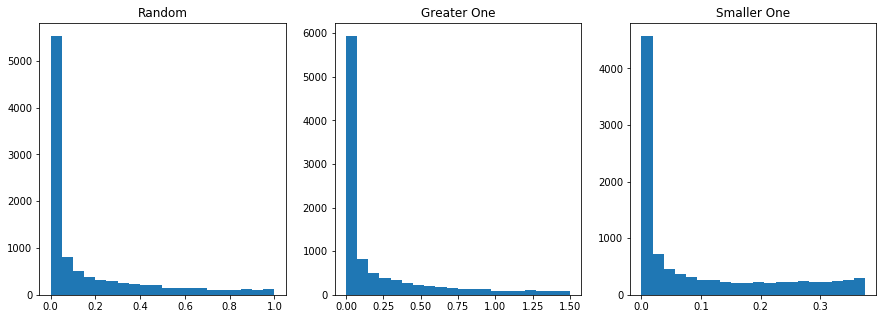

In [48]:
# power law 
random_distribution = np.random.power(0.2, size=(10000)) 

def box1(x,lmbda): return (np.power(x,lmbda) - 1)/lmbda
def box2(x,lmbda): return (np.power((x+1),lmbda) - 1) / lmbda
box_cox1 = box2(random_distribution,2)
box_cox2 = box2(random_distribution,-2)

plt.figure(figsize=(15,5))
plt.subplot(131); plt.hist(random_distribution.ravel(),batch_size); plt.title('Random')
plt.subplot(132); plt.hist(box_cox1.ravel(),batch_size); plt.title('Greater One')
plt.subplot(133); plt.hist(box_cox2.ravel(),batch_size); plt.title('Smaller One')
plt.show()   

# Reference
1. generator, B. (2018). Bernoulli random number generator. Stack Overflow. Retrieved 14 December 2018, from https://stackoverflow.com/questions/47012474/bernoulli-random-number-generator
2. right?, D. (2018). Derivative of Binary Cross Entropy - why are my signs not right?. Mathematics Stack Exchange. Retrieved 14 December 2018, from https://math.stackexchange.com/questions/2503428/derivative-of-binary-cross-entropy-why-are-my-signs-not-right
3. 